# Analysis of Transfer Learning AMBER search

In [1]:
%cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
import json
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import amber
%matplotlib inline

Using TensorFlow backend.


In [3]:
def read_action_weights(fns):
    """read 'weight_data.json'
    """
    dfs = defaultdict(lambda: defaultdict(list))
    for fn in fns:
        with open(fn, 'r') as f:
            data = json.load(f)
        for layer in data:
            for layer_name, dat in data[layer]['operation'].items():
                if layer_name.startswith(('kinn', 'inception', 'attentionpooling')):
                    layer_name = layer_name.split()[-1].strip("}'").lower()
                    layer_name = 'attn_flatten' if layer_name == 'atnflat' else layer_name
                elif layer_name.startswith('dropout'):
                    layer_name = "dropout_%s" % (layer_name.split()[-1].strip("}'"))
                elif layer_name.startswith('bidirection'):
                    layer_name = "bidirection_%s"%layer_name.split()[-1].strip("}'")
                layer_name = layer_name.replace('_relu', '')
                dfs[layer][layer_name].extend(dat)
    df = {}
    for layer in dfs:
        df[layer] = pd.DataFrame(dfs[layer])
    return dfs

In [4]:
df = read_action_weights(["outputs/2022-11-01/TL_%i/weight_data.json"%i for i in range(1,6)])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


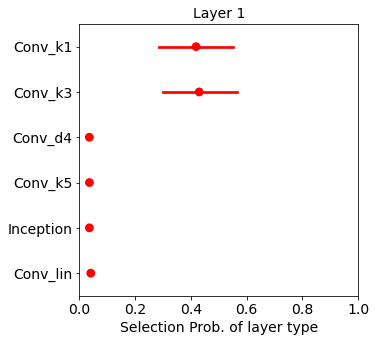

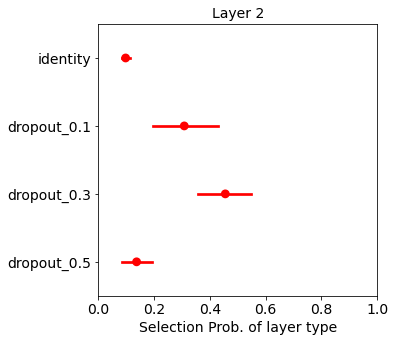

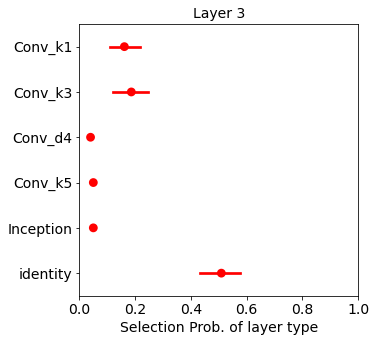

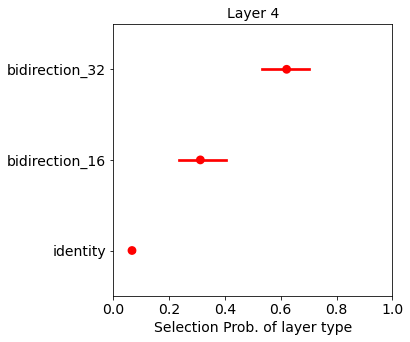

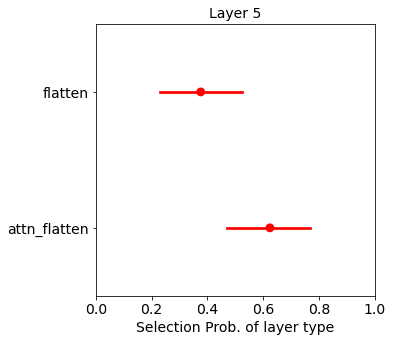

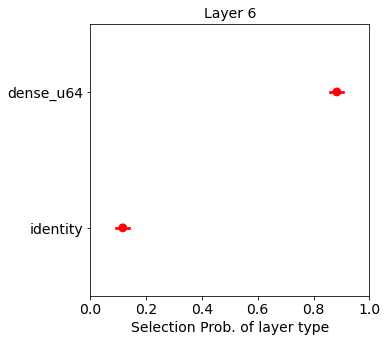

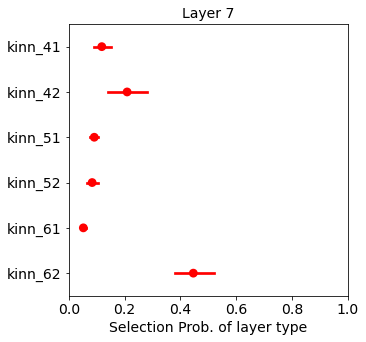

In [5]:
n_last = 5
for layer in df:
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    plot_df = pd.DataFrame(columns=['token', 'prob'])
    for layer_name, data in df[layer].items():
        d = np.array(data)
        if layer_name.startswith('inception'):
            layer_name = 'Inception'
        if layer_name.endswith('linear'):
            layer_name = 'Conv_lin'
        if layer_name.startswith('conv'):
            layer_name = 'Conv_%s' % layer_name.split('_')[-1]
        if layer_name.startswith('kinn'):
            layer_name = 'kinn_' + layer_name.split('_')[1][1:]
        for num in d[:, -n_last:].flatten():
            plot_df=plot_df.append({'token': layer_name, 'prob': num}, ignore_index=True)

    sns.pointplot(y='token', x='prob', join=False, data=plot_df, color='red')
    ax.set_ylabel('')
    ax.set_xlabel('Selection Prob. of layer type')
    ax.set_xlim(0,1)
    ax.set_title(f'Layer {int(layer.strip("L"))+1}')
    # save as source_data
    if layer in ['L0', 'L2', 'L3', 'L6']:
        plot_df.to_csv(f'source_data/Fig3_layer{int(layer.strip("L"))+1}.csv')
    else:
        plot_df.to_csv(f'source_data/SuppFig6_layer{int(layer.strip("L"))+1}.csv')

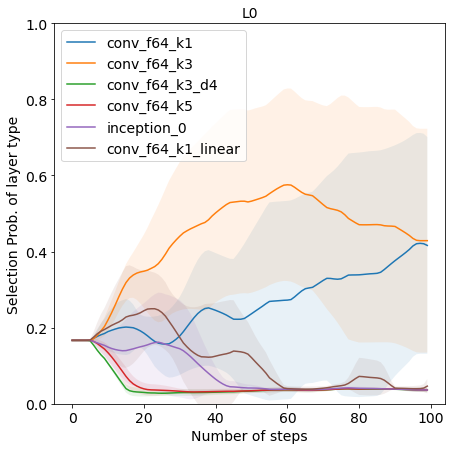

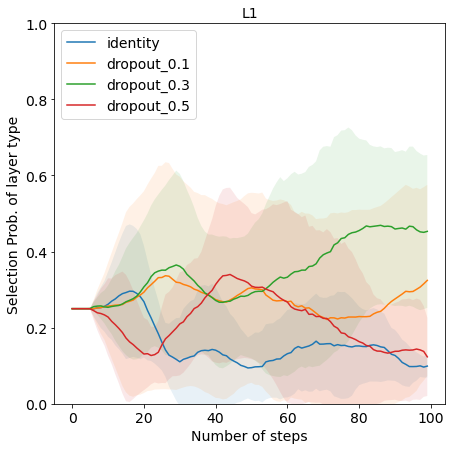

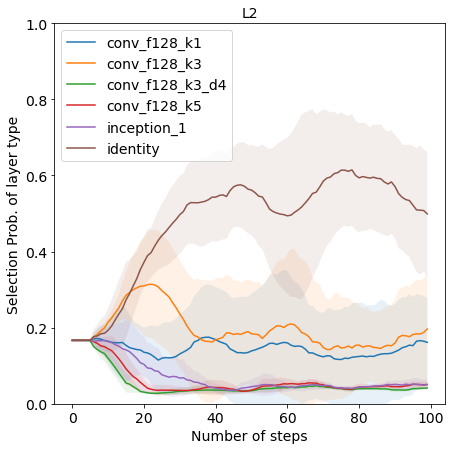

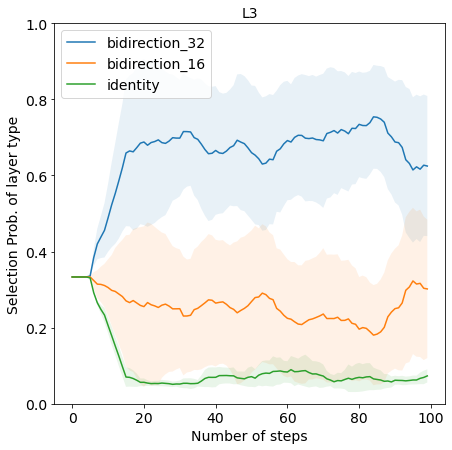

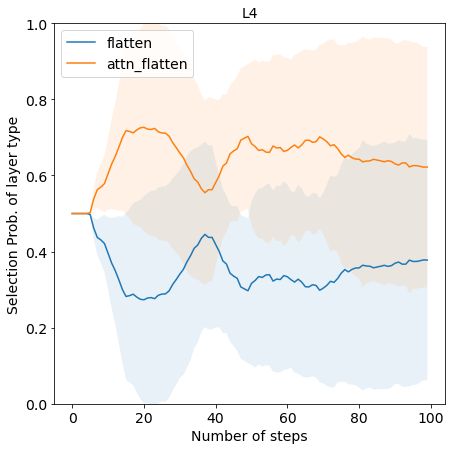

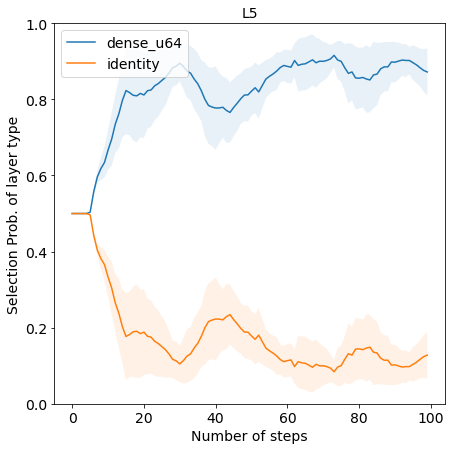

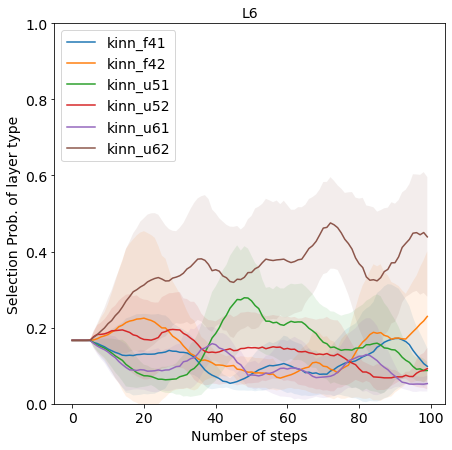

In [6]:
for layer in df:
    fig, ax = plt.subplots(1,1, figsize=(7,7))

    for layer_name, data in df[layer].items():
        d = np.array(data)
        if d.shape[0] >= 2:
            avg = np.apply_along_axis(np.mean, 0, d)
        else:
            avg = np.array(d).reshape(d.shape[1])
        ax.plot(avg, label=layer_name)
        if d.shape[0] >= 5:
            # hand-computed 95% CI
            std = np.apply_along_axis(np.std, 0, d) / np.sqrt(d.shape[0])
            min_, max_ = avg - 1.96 * std, avg + 1.96 * std
            ax.fill_between(range(avg.shape[0]), min_, max_, alpha=0.1)

    # Put a legend to the right of the current axis
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.legend(loc='upper left')

    ax.set_ylim(0,1)
    ax.set_xlabel('Number of steps')
    ax.set_ylabel('Selection Prob. of layer type')
    ax.set_title(layer)

In [7]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Oct 19 2023

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.22.0

amber     : 0.1.3
seaborn   : 0.11.1
pandas    : 1.0.3
json      : 2.0.9
numpy     : 1.19.5
matplotlib: 3.4.3

Watermark: 2.3.1

